In [1]:
%matplotlib inline
%config InlineBackend.figure_format = {'svg', 'png'}[0]

In [2]:
import os, copy, time, pickle
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

import torch
from torch.distributions import Categorical, Normal

import gymnasium as gym
from gymnasium.wrappers import TimeLimit


from reinforce_agent import *
from surrogate import *

np.set_printoptions(precision=3, suppress=True, floatmode='fixed', linewidth=150)

In [3]:
class PropInteDiff(object):
    def __init__(self, kp, ki, kd, limits_out_all=[None, None]):
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.limits_out_all = limits_out_all

        # internals
        self.err_cur = 0
        self.err_last = None
        self.err_sum = 0

        self.ep = 0
        self.ei = 0
        self.ed = 0

        self.out_p = 0
        self.out_i = 0
        self.out_d = 0
        self.out_all = 0

    def step(self, err, dt):
        '''The current error should be the expected value minus the current value.
        '''
        self.err_cur = err
        self.err_sum = self.err_sum + self.err_cur

        self.ep = self.err_cur
        self.ei = self.err_sum
        self.ed = self.err_cur - (self.err_last if (self.err_last is not None) else self.err_cur)

        self.out_p = self.kp * self.ep
        self.out_i = self.ki * self.ei * dt
        self.out_i = np.clip(self.out_i, *self.limits_out_all)
        self.out_d = self.kd * self.ed / dt

        self.out_all = self.out_p + self.out_i + self.out_d
        self.out_all = np.clip(self.out_all, *self.limits_out_all)
        
        self.err_last = self.err_cur
        return self.out_all

    def reset(self):
        self.err_cur = 0
        self.err_last = None
        self.err_sum = 0

        self.ep = 0
        self.ei = 0
        self.ed = 0

        self.out_p = 0
        self.out_i = 0
        self.out_d = 0
        self.out_all = 0 

In [4]:
def homogeneous_rotation_matrix(theta) -> np.ndarray:
    rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta), np.cos(theta), 0],
        [0, 0, 1]
    ])
    return rotation_matrix


def homogeneous_translation_matrix(translation) -> np.ndarray:
    translation_matrix = np.array([
        [1, 0, translation[0]],
        [0, 1, translation[1]],
        [0, 0, 1]
    ])
    return translation_matrix


def homogeneous_transformation_matrix(translation, theta):
    translation_matrix = homogeneous_translation_matrix(translation)
    rotation_matrix = homogeneous_rotation_matrix(theta)
    transformation_matrix = np.dot(translation_matrix, rotation_matrix)
    return transformation_matrix


def decompose_transformation_matrix(T):
    translation = T[:2, 2]
    rotation = T[:2, :2]
    return translation, rotation


def extract_theta_from_rotation(rotation_matrix):
    theta = np.arctan2(rotation_matrix[1, 0], rotation_matrix[0, 0])
    return theta


def coordinate_transfer(tf, pose2d):    
    t, r = decompose_transformation_matrix(np.dot(tf, homogeneous_transformation_matrix(pose2d[:-1], pose2d[-1])))
    return np.array([t[0], t[1], extract_theta_from_rotation(r)])


def mapping_period(ori_angle, angle_range) -> np.ndarray:
    lower, upper = angle_range
    period = upper - lower
    res_angle = ori_angle % period
    if res_angle > upper:
        res_angle = res_angle - period
    return res_angle

In [5]:
class Controller():    
    def __init__(self, name:str) -> None:
        self.name = name
    
    def reset(self) -> None:
        self.time = 0
    
    def get_action(self, obs:np.ndarray, dt:float, **kwargs) -> np.ndarray:
        self.time += dt
    

class DiscreteDrlController(Controller):
    def __init__(self, name, pi_wb_path, obs_dims, act_nums, hidden_size, device:str) -> None:
        super().__init__(name)
        self.device = torch.device(device)
        self.pi_net = DiscretePolicyNetwork(obs_dims, act_nums, hidden_size).to(self.device)
        
        assert os.path.exists(pi_wb_path), f"Path '{pi_wb_path}' of weights and biases is NOT exist."
        self.pi_net.load_state_dict(torch.load(pi_wb_path))
        self.pi_net.eval()
    
    def get_action(self, obs:np.ndarray, dt:float, deterministic=True) -> np.ndarray:
        super().get_action(obs, dt)
        prob = self.pi_net(torch.FloatTensor(obs).to(self.device))
        if deterministic:
            act = torch.argmax(prob, dim=0)
        else:
            act = Categorical(prob).sample()
        return act.detach().cpu().numpy()

In [6]:
def print_format(ax, title, xlabel, ylabel, xlim=None, ylim=None):
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    if xlim is not None:
        ax.set_xlim(*xlim)
    if ylim is not None:
        ax.set_ylim(*ylim)
    
    ax.set_aspect(1)

    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())

    ax.tick_params(axis='both', which='both', direction='in', top=True, right=True)

    # ax.legend()
    ax.grid(True)


def print_pose(ax, pose, l, c, label):
    ax.plot(pose[0], pose[1], marker='.', color=c, label=label)
    ax.plot([pose[0], pose[0] + np.cos(pose[2]) * l], [pose[1], pose[1] + np.sin(pose[2]) * l], color=c)

In [7]:
def one_episode_rollout(env:gym.Env, controller:Controller, deterministic=True, verbose=1):
    log = []
    
    if controller is not None:
        controller.reset()
    
    obs, info = env.reset()
    while True:
        if controller is not None:
            act = controller.get_action(obs, env.dt, deterministic=deterministic)
        else:
            act = env.action_space.sample()
        
        next_obs, rew, ter, tru, info = env.step(act)
        
        if verbose >= 2:
            print(obs, act, next_obs, rew, ter, tru, info)
        
        log.append({
            'state':copy.deepcopy(env.state),
            'obs':obs,
            'act':act,
            'next_obs':next_obs,
            'rew':rew,
        })

        obs = next_obs

        if ter or tru:
            break

    log = {key: np.array([d[key] for d in log]) for key in log[0]}
    
    if verbose >= 1:
        print(f"The episodic length is: {len(log['rew'])} and episodic return is: {log['rew'].sum()}.")
    
    return log, log['rew'].sum()

## Position Control Task

pid
The average return of 1 episode(s) is: 0.75
rl


/home/linxzh/anaconda3/envs/oceanus/lib/python3.8/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.dt to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.dt` for environment variables or `env.get_wrapper_attr('dt')` that will search the reminding wrappers.
  logger.warn(
/home/linxzh/anaconda3/envs/oceanus/lib/python3.8/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.state to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.state` for environment variables or `env.get_wrapper_attr('state')` that will search the reminding wrappers.
  logger.warn(


The average return of 1 episode(s) is: 0.73


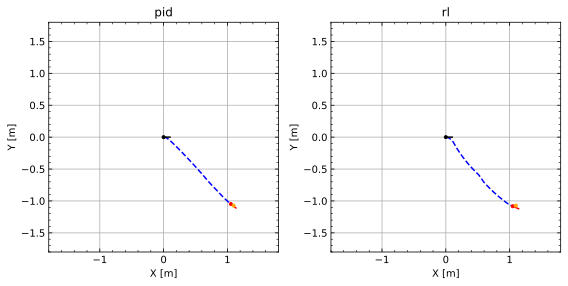

In [8]:
class PositionControlController(Controller):
    def __init__(self, name:str, kp:float, ki:float, kd:float) -> None:
        super().__init__(name)
        self.pid = PropInteDiff(kp, ki, kd, limits_out_all=[-0.5, 0.5])

        self.D = np.array([[0.14, 0.13], [0.15, 0.16], [0.15, 0.15], [0.15, 0.17], [0.15, 0.16], [0.14, 0.16], [0.16, 0.16]])
        self.A = np.array([[-0.26, -0.41], [-0.10, -0.24], [-0.06, -0.15], [0.01, -0.04], [0.11, 0.11], [0.20, 0.13], [0.24, 0.38]])
        self.X_m = np.array([[-0.26, -0.26], [-0.18, -0.18], [-0.09, -0.09], [0, 0], [0.18, 0.18], [0.26, 0.26], [0.35, 0.35]])  # rad
    
    def reset(self) -> None:
        super().reset()
        self.pid.reset()

    def get_action(self, obs:np.ndarray, dt:float, **kwargs) -> np.ndarray:
        super().get_action(obs, dt)
        ta, v, d, eta = int(obs[0]), obs[1], obs[2], obs[3]
        
        u = self.pid.step(eta, dt)
        action = np.array(np.abs(self.X_m[:, ta] - u).argmin())
        return action
    

# setting
# env = gym.make('PositionControl-v0')
random_position = np.random.uniform(-1.5, 1.5, 2)  # [0.0, 0.5]
env = TimeLimit(PositionControlEnv(init_goal_condition=([random_position[0]], [random_position[1]])), max_episode_steps=100)

controllers = []
controllers.append(PositionControlController('pid', kp=0.95, ki=0.0, kd=0.0))
controllers.append(DiscreteDrlController('rl', './checkpoints/ab634024/10000/pi.pth', env.observation_space.shape[0], env.action_space.n, [256, 256], 'cuda'))


# visualization
fig, axs = plt.subplots(1, len(controllers), figsize=(len(controllers)*4, 4))

# interaction
for i, controller in enumerate(controllers):
    print(controller.name)

    returns = []
    for _ in range(1):
        rollout_data, episodic_return = one_episode_rollout(env, controller, deterministic=False, verbose=0)
        returns.append(episodic_return)
    print(f"The average return of {len(returns)} episode(s) is: {np.array(returns).mean()}")

    poses = np.stack(rollout_data['state'][-1]['world']['robot_pose'])
    goal_pose = rollout_data['state'][-1]['world']['task_goal_pose']

    axs[i].plot(poses[:, 0], poses[:, 1], color='blue', label='trajectory', marker='', linestyle='--')
    print_pose(axs[i], poses[0], 0.1, 'black', 'init pose')
    print_pose(axs[i], poses[-1], 0.1, 'red', 'final pose')
    axs[i].plot(goal_pose[0], goal_pose[1], marker='.', color='orange', label='goal position')

    print_format(axs[i], f'{controller.name}', 'X [m]', 'Y [m]', (-1.8, 1.8), (-1.8, 1.8))
        
plt.tight_layout()
plt.show()
# plt.savefig('./figs/pc.svg', bbox_inches='tight')

## Path Following Task

pid-line
The average return of 1 episode(s) is: 108.3
pid-eight
The average return of 1 episode(s) is: 126.0
rl-line
The average return of 1 episode(s) is: 97.8
rl-eight
The average return of 1 episode(s) is: 135.4


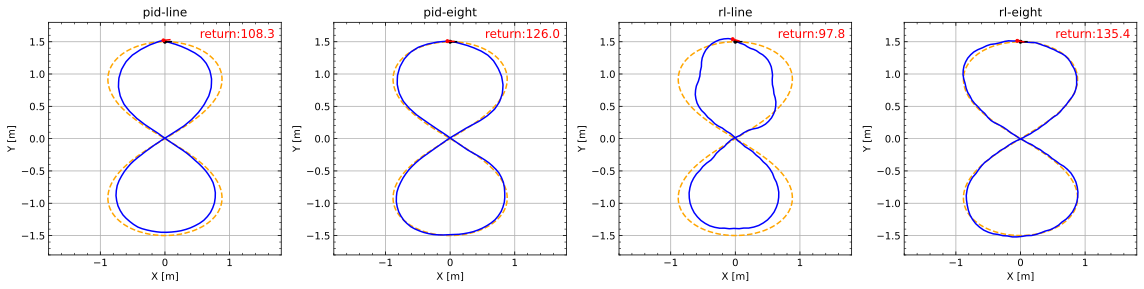

In [9]:
class PathFollowingController(Controller):
    '''[From Simulation to Reality: A Learning Framework for Fish-Like Robots to Perform Control Tasks](https://ieeexplore.ieee.org/document/9802680/)'''
    def __init__(self, name:str, kp_1=0.6, kp_2=2.0) -> None:
        super().__init__(name)
        self.kp_1 = kp_1
        self.kp_2 = kp_2

        self.D = np.array([[0.14, 0.13], [0.15, 0.16], [0.15, 0.15], [0.15, 0.17], [0.15, 0.16], [0.14, 0.16], [0.16, 0.16]])
        self.A = np.array([[-0.26, -0.41], [-0.10, -0.24], [-0.06, -0.15], [0.01, -0.04], [0.11, 0.11], [0.20, 0.13], [0.24, 0.38]])
        self.X_m = np.array([[-0.26, -0.26], [-0.18, -0.18], [-0.09, -0.09], [0, 0], [0.18, 0.18], [0.26, 0.26], [0.35, 0.35]])  # rad
    
    def reset(self) -> None:
        super().reset()

    def get_action(self, obs:np.ndarray, dt:float, **kwargs) -> np.ndarray:
        super().get_action(obs, dt)
        ta, v, d, psi, beta = int(obs[0]), obs[1], obs[2], obs[3], obs[4]

        u = np.clip(self.kp_1 * mapping_period(beta - psi, [-np.pi, np.pi]) + self.kp_2 * d, -0.5, 0.5)
        action = np.array(np.abs(self.A[:, ta] - u).argmin())
        return action
    

# setting
# env = gym.make('PathFollowing-v0')
# random_pose = [-0.25, -0.25, -np.pi/4]
random_pose = [0.0, 0.0, 0.0]
# random_pose = np.random.uniform([-0.25, -0.25, -np.pi/2], [0.25, 0.25, np.pi/2])
env = TimeLimit(PathFollowingEnv(goal_path_type='eight', init_pose_condition=([random_pose[0]], [random_pose[1]], [random_pose[2]])), max_episode_steps=200)

controllers = []
controllers.append(PathFollowingController('pid-line', kp_1=1.2, kp_2=1.5))
controllers.append(PathFollowingController('pid-eight', kp_1=0.6, kp_2=2.0))
controllers.append(DiscreteDrlController('rl-line', './models/path_following/79959468/1265/pi.pth', env.observation_space.shape[0], env.action_space.n, [256, 256], 'cuda'))
controllers.append(DiscreteDrlController('rl-eight', './models/path_following/fad9f62c/4700/pi.pth', env.observation_space.shape[0], env.action_space.n, [256, 256], 'cuda'))


# visualization
fig, axs = plt.subplots(1, len(controllers), figsize=(len(controllers)*4, 4))

# interaction
for i, controller in enumerate(controllers):
    if controller is not None:
        print(controller.name)

    returns = []
    for _ in range(1):
        rollout_data, episodic_return = one_episode_rollout(env, controller, deterministic=False, verbose=0)
        returns.append(episodic_return)
        # if episodic_return <= 50:
        #     break
    print(f"The average return of {len(returns)} episode(s) is: {round(np.array(returns).mean(), 1)}")

    poses = np.stack(rollout_data['state'][-1]['world']['robot_pose'])
    goal_pose = rollout_data['state'][-1]['world']['task_goal_pose']

    axs[i].plot(goal_pose[:, 0], goal_pose[:, 1], color='orange', label='goal path', marker='', linestyle='--')
    axs[i].plot(poses[:, 0], poses[:, 1], color='blue', label='trajectory', marker='', linestyle='-')
    print_pose(axs[i], poses[0], 0.1, 'black', 'init pose')
    print_pose(axs[i], poses[-1], 0.1, 'red', 'final pose')
    axs[i].text(1.7, 1.7, f'return:{round(np.array(returns).mean(), 1)}', horizontalalignment='right', verticalalignment='top', fontsize=12, color='red')

    print_format(axs[i], f'{controller.name}', 'X [m]', 'Y [m]', (-1.8, 1.8), (-1.8, 1.8))
        
plt.tight_layout()
plt.show()
# plt.savefig('./figs/pf-eight.svg', bbox_inches='tight')

## Pose Regulation Task

random
The successful rate of 10 episode(s) is: 0.0
pid
The successful rate of 10 episode(s) is: 1.0
il-pid
The successful rate of 10 episode(s) is: 0.0
rl-hard
The successful rate of 10 episode(s) is: 1.0


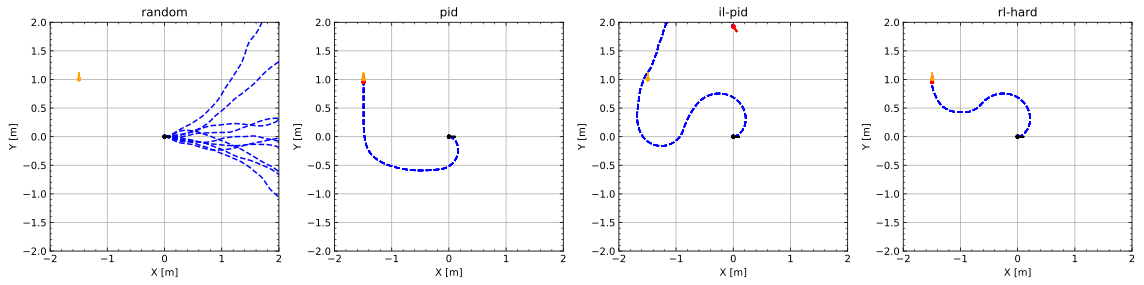

In [49]:
class PoseRegulationController(Controller):
    '''[CFD based parameter tuning for motion control of robotic fish](https://iopscience.iop.org/article/10.1088/1748-3190/ab6b6c)'''
    def __init__(self, name:str) -> None:
        super().__init__(name)
        self.D = np.array([[0.14, 0.13], [0.15, 0.16], [0.15, 0.15], [0.15, 0.17], [0.15, 0.16], [0.14, 0.16], [0.16, 0.16]])
        self.A = np.array([[-0.26, -0.41], [-0.10, -0.24], [-0.06, -0.15], [0.01, -0.04], [0.11, 0.11], [0.20, 0.13], [0.24, 0.38]])
        self.X_m = np.array([[-0.26, -0.26], [-0.18, -0.18], [-0.09, -0.09], [0, 0], [0.18, 0.18], [0.26, 0.26], [0.35, 0.35]])  # rad
    
    def reset(self) -> None:
        super().reset()
        self.stage = 0

    def get_action(self, obs:np.ndarray, dt:float, **kwargs) -> np.ndarray:
        super().get_action(obs, dt)
        ta, v, diff_p, diff_phi, eta = int(obs[0]), obs[1], obs[2], obs[3], obs[4]
    
        x_L = - np.cos(mapping_period(diff_phi - eta, [-np.pi, np.pi])) * diff_p
        y_L = np.sin(mapping_period(diff_phi - eta, [-np.pi, np.pi])) * diff_p

        if self.stage == 0:                
            theta_aux1 = mapping_period((0.95 * np.pi) * np.sign(y_L), [-np.pi, np.pi])
            u = 0.5 * mapping_period(- diff_phi - theta_aux1, [-np.pi, np.pi])

            self.stage = 1 if x_L <= -0.9 else self.stage
        elif self.stage == 1:
            theta_aux2 = mapping_period(- (2/3 * np.pi) * np.sign(y_L), [-np.pi, np.pi])
            u = 1.8 * mapping_period(- diff_phi, [-np.pi, np.pi]) + 5.5 * np.abs(y_L) * mapping_period(- diff_phi - theta_aux2, [-np.pi, np.pi])
            
            self.stage = 2 if np.abs(y_L) <= 0.2 else self.stage
        elif self.stage == 2:
            theta_aux2 = mapping_period(- (1/2 * np.pi) * np.sign(y_L), [-np.pi, np.pi])
            u = 2.6 * mapping_period(- diff_phi, [-np.pi, np.pi]) + 9.8 * np.abs(y_L) * mapping_period(- diff_phi - theta_aux2, [-np.pi, np.pi])
        
        action = np.array(np.abs(self.X_m[:, ta] + u).argmin())
        return action
    

# setting
random_pose = [1.4, -0.99, 0.01]  # Easy-Level Evaluation Case
random_pose = [1.5, -1.57, -0.15]  # Middle-Level Evaluation Case
random_pose = [1.8, 1.57, 2.55]  # Hard-Level Evaluation Case
env = TimeLimit(PoseRegulationEnv(init_goal_condition=([random_pose[0]], [random_pose[1]], [random_pose[2]])), max_episode_steps=100)

controllers = []
controllers.append(None)  # random
controllers.append(PoseRegulationController('pid'))  # 
controllers.append(DiscreteDrlController('il-pid', './models/pose_regulation/imitation_learning/pi.pth', env.observation_space.shape[0], env.action_space.n, [256, 256], 'cuda'))
# controllers.append(DiscreteDrlController('rl-easy', './models/pose_regulation/c67b1ae8/16200/pi.pth', env.observation_space.shape[0], env.action_space.n, [32], 'cuda'))
# controllers.append(DiscreteDrlController('rl-middle', './models/pose_regulation/d4aa9738/23600/pi.pth', env.observation_space.shape[0], env.action_space.n, [32], 'cuda'))
controllers.append(DiscreteDrlController('rl-hard', './models/pose_regulation/5bb24efe/32500/pi.pth', env.observation_space.shape[0], env.action_space.n, [32], 'cuda'))

# visualization
fig, axs = plt.subplots(1, len(controllers), figsize=(len(controllers)*4, 4))

# interaction
for i, controller in enumerate(controllers):
    if controller is not None:
        print(controller.name)
    else:
        print('random')

    returns = []
    for j in range(10):
        rollout_data, episodic_return = one_episode_rollout(env, controller, deterministic=True, verbose=0)
        returns.append(1 if episodic_return >= 0 else 0)

        poses = copy.deepcopy(np.stack(rollout_data['state'][-1]['world']['robot_pose']))
        goal_pose = copy.deepcopy(rollout_data['state'][-1]['world']['task_goal_pose'])

        axs[i].plot(poses[:, 0], poses[:, 1], color='blue', label='trajectory', marker='', linestyle='--')
        print_pose(axs[i], poses[0], 0.1, 'black', 'init pose')
        print_pose(axs[i], poses[-1], 0.1, 'red', 'final pose')
        print_pose(axs[i], goal_pose, 0.1, 'orange', 'goal pose')

        if controller is not None:
            print_format(axs[i], f'{controller.name}', 'X [m]', 'Y [m]', (-2.0, 2.0), (-2.0, 2.0))
        else:
            print_format(axs[i], 'random', 'X [m]', 'Y [m]', (-2.0, 2.0), (-2.0, 2.0))
    
    print(f"The successful rate of {len(returns)} episode(s) is: {np.array(returns).mean()}")
        
plt.tight_layout()
plt.show()
# plt.savefig('./figs/pr-hard.svg', bbox_inches='tight')

## Imitation Learning

In [ ]:
# hyper-params
env_name = 'PoseRegulationHard-v0'
max_episodes = 1e5
model_save_interval = 100

# setting
env = gym.make(env_name)
expert = PoseRegulationController('pid')  # based on 'PID' controller

# logger
uid = str(uuid.uuid1()).split('-')[0]
logger = SummaryWriter(log_dir=f"./tensorboard/{env_name}/il-{expert.name}/{uid}")

# imitation learning
pi_net = DiscretePolicyNetwork(env.observation_space.shape[0], env.action_space.n, [256, 256]).to(torch.device('cuda'))
pi_net.load_state_dict(torch.load('./checkpoints/5a9a6926/10000/pi.pth'))
pi_net_optim = torch.optim.Adam(pi_net.parameters(), lr=1e-3)


# interaction
episodes, returns = 10000, []
while episodes <= max_episodes:
    rollout_data, _ = one_episode_rollout(env, expert, verbose=0)
    
    obs, act = rollout_data['obs'], rollout_data['act']
    
    obs = torch.FloatTensor(obs).to(torch.device('cuda'))
    act = torch.LongTensor(act).to(torch.device('cuda'))

    # train
    pred_act = pi_net(obs)
    loss = torch.nn.NLLLoss()(torch.log(pred_act), act)  # cross entropy loss

    pi_net_optim.zero_grad()
    loss.backward()
    pi_net_optim.step()

    episodes += 1

    # eval
    if not os.path.exists(f"./checkpoints/{uid}/"):
        os.makedirs(f"./checkpoints/{uid}/")
    torch.save(pi_net.state_dict(), f"./checkpoints/{uid}/temp_pi.pth")
    student = DiscreteDrlController('il-pid', f"./checkpoints/{uid}/temp_pi.pth", env.observation_space.shape[0], env.action_space.n, [256, 256], 'cuda')
    _, episode_rew = one_episode_rollout(env, student, verbose=0)

    returns.append(episode_rew)
    average_return = np.array(returns).mean() if len(returns) <= 50 else np.array(returns[-51:-1]).mean()

    # verbose
    print(f"{uid} | Episodes: {episodes} | Episode Reward: {round(episode_rew, 5)} | Average Return: {round(average_return, 5)} | Loss: {loss.item()}")

    logger.add_scalar('episodic/return', episode_rew, episodes)
    logger.add_scalar('episodic/return(average)', average_return, episodes)
    logger.add_scalar('loss/pi', loss, episodes)

    # save model
    if episodes % model_save_interval == 0:
        if not os.path.exists(f"./checkpoints/{uid}/{episodes}/"):
            os.makedirs(f"./checkpoints/{uid}/{episodes}/")
        torch.save(pi_net.state_dict(), f"./checkpoints/{uid}/{episodes}/pi.pth")
